In [1]:
!pip install tensorflow_io==0.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.1 MB 1.5 MB/s 
     |████████████████████████████████| 2.1 MB 44.0 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.26.0
    Uninstalling tensorflow-io-gcs-filesystem-0.26.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.26.0


In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
CAPUCHIN_FILE = os.path.join('drive', 'MyDrive','Z by HP Unlocked Challenge 3','Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('drive', 'MyDrive','Z by HP Unlocked Challenge 3','Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [7]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [8]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

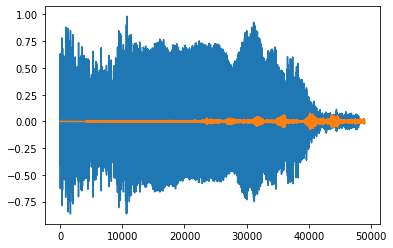

In [9]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [10]:
POS = os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Parsed_Capuchinbird_Clips')
NEG = os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Parsed_Not_Capuchinbird_Clips')

In [11]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [12]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [13]:
lengths = []
for file in os.listdir(os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [14]:
print(lengths)
print(tf.math.reduce_mean(lengths))
print(tf.math.reduce_min(lengths))
print(tf.math.reduce_max(lengths))

[64000, 64000, 48000, 64000, 40000, 56000, 48000, 56000, 48000, 56000, 64000, 64000, 56000, 48000, 56000, 64000, 56000, 64000, 56000, 64000, 56000, 56000, 64000, 56000, 56000, 40000, 56000, 48000, 56000, 64000, 64000, 64000, 56000, 48000, 64000, 64000, 56000, 56000, 56000, 40000, 32000, 64000, 48000, 56000, 48000, 48000, 48000, 40000, 56000, 56000, 48000, 48000, 48000, 40000, 40000, 40000, 64000, 56000, 56000, 64000, 56000, 48000, 48000, 48000, 48000, 48000, 48000, 56000, 56000, 40000, 48000, 56000, 56000, 56000, 56000, 72000, 64000, 48000, 40000, 56000, 48000, 56000, 56000, 56000, 64000, 56000, 48000, 48000, 56000, 56000, 64000, 64000, 64000, 40000, 56000, 40000, 64000, 48000, 48000, 48000, 56000, 64000, 64000, 64000, 48000, 48000, 48000, 48000, 48000, 56000, 56000, 56000, 56000, 64000, 64000, 64000, 48000, 56000, 55999, 56000, 32000, 32000, 40000, 56000, 56000, 48000, 40000, 40000, 64000, 56000, 48000, 48000, 40000, 56000, 48000, 48000, 48000, 64000, 56000, 55999, 48000, 48000, 72000

In [15]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

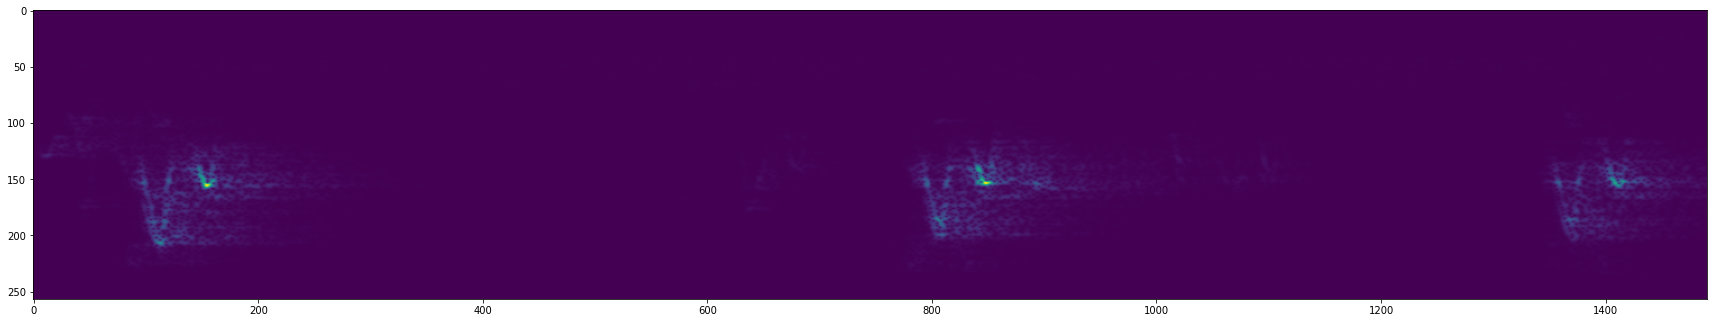

In [16]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()